# Building A Multi Layer Perceptron

## Building Training Dataset

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plot
%matplotlib inline
import random

In [7]:
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)

32033

In [9]:
# build vocab and mappings
chars = sorted(list(set(''.join(words))))
chtoi ={ch:i+1 for i, ch in enumerate(chars)} # char to int mapping
chtoi['.'] = 0 # add separator
itoch = {i:ch for ch, i in chtoi.items()} # int to char mapping
print(itoch)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
# building the dataset
block_size = 3 

`block_size` represents the context length i.e. how many characters does the model take to predict the next one.

### Dataset For First Three Words

In [7]:
X, Y = [], []

for w in words[:3]:
    print(w)
    context = [0] * block_size ## start with padded context of 0s
    for ch in w + '.':
        ix = chtoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itoch[i] for i in context), '->', itoch[ix])
        context = context[1:] + [ix] # update the context window by removing first element and adding ix at the end

emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
ava
... -> a
..a -> v
.av -> a
ava -> .


In [8]:
print(f'inputs:\n{X}\n')
print(f'targets:\n{Y}\n')

inputs:
[[0, 0, 0], [0, 0, 5], [0, 5, 13], [5, 13, 13], [13, 13, 1], [0, 0, 0], [0, 0, 15], [0, 15, 12], [15, 12, 9], [12, 9, 22], [9, 22, 9], [22, 9, 1], [0, 0, 0], [0, 0, 1], [0, 1, 22], [1, 22, 1]]

targets:
[5, 13, 13, 1, 0, 15, 12, 9, 22, 9, 1, 0, 1, 22, 1, 0]



In [9]:
X = torch.tensor(X)
Y = torch.tensor(Y)

Notice that out of the word "emma" we can generate 5 different example for inputs and targets.

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

### Complete Dataset

In [11]:
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = chtoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y) 

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

## Building The Embedding Table

Let's create an embedding table for characters in which each character has a `2D` embedding. 

In [12]:
C = torch.randn((27, 2)) # creating a 2D vector space for a 27 token vocab size
C 

tensor([[-0.8906, -0.5311],
        [-0.7126,  0.6650],
        [-3.0509, -1.3005],
        [ 1.2423, -0.0122],
        [-1.2658, -0.3378],
        [ 0.3598, -1.5086],
        [ 1.5201,  0.9473],
        [-1.0241, -1.7311],
        [-0.0567,  1.4352],
        [ 0.2790,  0.3943],
        [ 1.0450,  0.8230],
        [ 0.6546, -1.3727],
        [-0.6181, -1.3810],
        [-0.0454,  0.9800],
        [-0.2716, -0.8130],
        [-0.2330,  0.1650],
        [ 0.9192, -1.1316],
        [-0.4429,  0.7039],
        [-1.3019,  1.0048],
        [-0.1629, -0.5099],
        [ 0.5418, -0.5218],
        [ 0.4291,  1.1844],
        [-0.2834,  0.0334],
        [-0.3032, -1.1619],
        [-0.0396,  0.8266],
        [ 0.4836,  0.8985],
        [-0.1452, -0.7643]])

Embedding for the integer 5 in the embedding lookup table is:

In [13]:
C[5] # row corresponsding to index 5 in the embedding table

tensor([ 0.3598, -1.5086])

Earlier(for Single Layer Bigram) we used `one-hot` vector encoding which looked like this:

In [14]:
F.one_hot(torch.tensor(5), num_classes=27) # encoding integer 5 to a vector

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [15]:
F.one_hot(torch.tensor(5), num_classes=27).shape

torch.Size([27])

When we matmul our 1 dim `one-hot` vector for the integer 5 with our 2D embedding table we get the same value because all the 0s in the `one-hot` matrix nullify all the other rows of `C` and only keep the row corresponding to index 5.

In [16]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.3598, -1.5086])

So the embedding of an integer can either be seen as the integer indexing into a lookup table C or it can be seen as the first layer of the larger NN (`x @ w` operation b/w `one_hot` vectors and weights matrix `C`). The neurons in this layer have no non-linearity and their weight matrix is C. We are encoding ints in one-hot and then feeding them to this layer.

### Getting Embeddings Of Multiple Integers

We pass a list of indices to get the corresponding rows from a tensor.

In [17]:
C[[5, 6, 7]]

tensor([[ 0.3598, -1.5086],
        [ 1.5201,  0.9473],
        [-1.0241, -1.7311]])

In [18]:
C[torch.tensor([5, 6, 7])]

tensor([[ 0.3598, -1.5086],
        [ 1.5201,  0.9473],
        [-1.0241, -1.7311]])

We can get the embeddings for our inputs by indexing with our inputs tensor `X` using multi dim indexing.

In [19]:
C[X][:3] # embeddings for first three inputs

tensor([[[-0.8906, -0.5311],
         [-0.8906, -0.5311],
         [-0.8906, -0.5311]],

        [[-0.8906, -0.5311],
         [-0.8906, -0.5311],
         [ 0.3598, -1.5086]],

        [[-0.8906, -0.5311],
         [ 0.3598, -1.5086],
         [-0.0454,  0.9800]]])

Now we have vector embeddings for our inputs X.

In [20]:
X.shape

torch.Size([228146, 3])

In [21]:
C[X].shape # for everyone of the vectors in X we have a 2D embedding

torch.Size([228146, 3, 2])

In [22]:
# example 
print(X[13, 2])
print(C[X][13, 2])
print(C[1])

tensor(1)
tensor([-0.7126,  0.6650])
tensor([-0.7126,  0.6650])


In [23]:
# so embedding all ints
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

## Implementing The Hidden Layer

According to the paper we have 3 inputs of 2 dims (in our case) so the number of inputs for this layer is 6. Let's take the number of neurons in this layer to be 100 (upto us).

In [24]:
W1 = torch.randn((6, 100)) # weights
B1 = torch.randn(100) # biases

We want to do the operation `emb @ W + b` but the embeddings are stacked in the input tensor so matmul will not work. So we need to concatenate these inputs together.

In [25]:
emb[:, 0, :].shape # get everything at the 0 index

torch.Size([228146, 2])

In [26]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # concatenate the seq across dim 1

torch.Size([228146, 6])

In [27]:
# to generalize the above operation
len(torch.unbind(emb, 1)) # list of tensors as in the above operation

3

In [28]:
# so now we can do the general operation
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

Turns out there is an even better way of doing this.

In [29]:
example = torch.arange(18)
example

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [30]:
# we can represent example tensor in different sized n dim tensors
example.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [31]:
example.view(3, 3, 2) # product of dim numbers should be the same

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In pytorch `.view` operation is extremely efficient because a tensor is stored as a 1D sequence of bytes in memory and the attributes of the tensor add the dimesionality to it. When we call `.view` we only modify these attributes but the underlying tensor remains the same in memory.

In [32]:
emb.shape

torch.Size([228146, 3, 2])

In [35]:
emb.view(228146, 6)[:5] # embeddings for the input name ".emma"

tensor([[-0.8906, -0.5311, -0.8906, -0.5311, -0.8906, -0.5311],
        [-0.8906, -0.5311, -0.8906, -0.5311,  0.3598, -1.5086],
        [-0.8906, -0.5311,  0.3598, -1.5086, -0.0454,  0.9800],
        [ 0.3598, -1.5086, -0.0454,  0.9800, -0.0454,  0.9800],
        [-0.0454,  0.9800, -0.0454,  0.9800, -0.7126,  0.6650]])

So we can get the hidden states of the hidden layer by:

In [36]:
h = emb.view(228146, 6) @ W1 + B1

In [37]:
h.shape

torch.Size([228146, 100])

### General Code For Setting Dimensionality Using Pytorch

We're hardcoding input's first dimension when we have already set dimensions of `W1` and `B1` so we can let pytorch figure out the first dimension of `emb` to successfully be able to perform matmul.

In [38]:
h = emb.view(-1, 6) @ W1 + B1 # -1 means pytorch can derive the appropriate dim

In [40]:
h[:1] # first row of logits

tensor([[ 0.2917,  1.1343, -1.5236, -2.1991, -0.6053,  0.1723, -2.1450, -3.8016,
         -0.2815,  0.2332, -5.0328,  1.9211, -1.8904,  4.6935,  1.1572,  2.6128,
         -2.4376,  1.2075,  0.2817, -0.8792,  0.6104,  0.6143,  1.0821,  1.6762,
          4.1587,  0.6786, -2.4657, -0.2951,  0.9624,  0.0517, -1.6315, -1.7829,
          1.9271, -1.6821,  4.3422,  0.4588,  0.4027, -5.5650, -0.6370, -1.3417,
         -1.2320,  1.0972, -4.2203, -2.2822,  0.1054,  1.2738, -3.9300, -2.7390,
         -0.2819, -1.9265, -0.7673,  3.3669, -2.0746, -1.9005,  0.3209, -1.4106,
          1.6125,  0.2961,  1.1174, -0.1609, -0.0729, -0.9407,  0.0643, -0.6233,
         -0.5157, -2.5226, -3.9342, -5.0516,  2.8137, -0.1331,  0.0928, -0.3633,
          1.0949,  1.3988,  0.8421, -3.0594,  2.0840, -0.4273, -2.5538,  2.0100,
         -1.7992, -1.5457,  1.9365,  2.4921, -1.1624,  1.5766,  1.3385, -0.7364,
          0.1856, -1.6967, -0.8301,  1.4838, -1.6395,  1.3107,  1.2011,  2.7978,
          1.3117,  4.0193, -

So now we perform a `tanh` (from the paper) to get the 100 dimensional activations of all of our 16 examples.

In [42]:
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)

In [43]:
h[:1] # first row after non linearity

tensor([[ 0.2837,  0.8125, -0.9093, -0.9757, -0.5408,  0.1706, -0.9730, -0.9990,
         -0.2743,  0.2290, -0.9999,  0.9580, -0.9554,  0.9998,  0.8201,  0.9893,
         -0.9848,  0.8359,  0.2745, -0.7060,  0.5444,  0.5471,  0.7940,  0.9324,
          0.9995,  0.5906, -0.9857, -0.2869,  0.7454,  0.0516, -0.9263, -0.9450,
          0.9585, -0.9331,  0.9997,  0.4291,  0.3823, -1.0000, -0.5628, -0.8721,
         -0.8432,  0.7995, -0.9996, -0.9794,  0.1050,  0.8548, -0.9992, -0.9917,
         -0.2746, -0.9584, -0.6454,  0.9976, -0.9689, -0.9563,  0.3103, -0.8876,
          0.9235,  0.2878,  0.8067, -0.1596, -0.0728, -0.7355,  0.0642, -0.5534,
         -0.4744, -0.9872, -0.9992, -0.9999,  0.9928, -0.1323,  0.0925, -0.3481,
          0.7987,  0.8851,  0.6869, -0.9956,  0.9695, -0.4031, -0.9880,  0.9647,
         -0.9467, -0.9131,  0.9593,  0.9864, -0.8218,  0.9181,  0.8713, -0.6270,
          0.1835, -0.9350, -0.6805,  0.9022, -0.9274,  0.8645,  0.8340,  0.9926,
          0.8647,  0.9994, -

## Implementing The Output Layer

In [44]:
W2 = torch.randn((100, 27)) # input is 100 and output number of neurons is 27 for our vocab size
B2 = torch.randn(27)

In [45]:
logits = h @ W2 + B2

In [46]:
logits.shape

torch.Size([228146, 27])

In [47]:
# getting prob dist from logits
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([228146, 27])

In [48]:
probs[0]

tensor([6.7285e-13, 8.5982e-12, 1.6140e-13, 1.1861e-10, 5.1992e-04, 9.0563e-05,
        1.2039e-13, 1.6621e-13, 6.7405e-06, 4.4342e-09, 2.0104e-07, 3.9948e-17,
        6.7446e-03, 1.0043e-14, 3.6358e-12, 1.5328e-04, 3.8162e-07, 8.6800e-05,
        1.2762e-09, 4.1578e-04, 5.3438e-12, 1.6612e-08, 1.0702e-14, 4.8616e-12,
        1.9638e-14, 8.8782e-10, 9.9198e-01])

In [49]:
probs[0].sum()

tensor(1.)

## Loss Function

In [51]:
# iterate through the rows of probs
probs[torch.arange(228146), Y] # probs assigned by this NN to the correct character in the seq

tensor([9.0563e-05, 9.2399e-16, 3.8735e-13,  ..., 6.3657e-06, 5.7874e-03,
        3.6027e-10])

In [53]:
nlll = - probs[torch.arange(228146), Y].log().mean() # negative log likelihood loss
nlll

tensor(18.8843)

## Cross Entropy As Loss

When we use `F.cross_entropy` pytorch doesn't create the intermediate tensors and evaluates all these operations in a very efficient manner. The expressions also take a much simpler form mathematically which makes it easier to perform a backward pass.

In [54]:
loss = F.cross_entropy(logits, Y)
loss

tensor(18.8843)

### Why Is It Better?

In [ ]:
# example of when cross_entropy is better than the other version
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [ ]:
# lets try that again but with one of the logits being a large value
logits = torch.tensor([-2, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [ ]:
counts

tensor([0.1353, 0.0498, 1.0000,    inf])

If we pass a very positive number as logit, we run out of range for floating point number and it gets rounded off as `inf` which leads to `nan`.

## Training Loop

In [59]:
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
B1 = torch.randn(100)
W2 = torch.randn((100, 27))
B2 = torch.randn(27)
parameters = [C, W1, B1, W2, B2]

In [60]:
sum(p.nelement() for p in parameters)

3481

In [61]:
for p in parameters:
    p.requires_grad = True

In [62]:
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 *p.grad

16.690427780151367
15.810751914978027
15.034162521362305
14.460734367370605
13.929698944091797
13.432076454162598
12.966328620910645
12.53366470336914
12.135788917541504
11.771121978759766


## Training Using Mini Batches

### Generating random indices for sampling from our input

In [ ]:
# generate 32 numbers b/w 0 and 5
torch.randint(0, 5, (32, ))

tensor([2, 0, 3, 1, 1, 3, 3, 1, 2, 3, 4, 3, 4, 1, 2, 0, 0, 0, 4, 4, 1, 2, 4, 2,
        2, 4, 4, 3, 2, 1, 4, 2])

In [ ]:
torch.randint(0, X.shape[0], (32, )) # integers that can index into our dataset

tensor([192243,  52594, 109420, 153200, 141591,  98267,   3361, 188364, 125425,
        138160,   4298, 120692,  94276,  68859, 177697, 146915,  92682,  49447,
        115655,  81626, 133559,  80606,  60174,  85853, 194280, 202666, 133599,
        177270, 139566, 175848,  87711, 198502])

These are the row indicies we can use to pick random samples of input for our batches. Here we choose 32 random indices so our `batch_size`=32.

In [81]:
batch_size = 32

for _ in range(1000):
    # creating mini batch
    ix = torch.randint(0, X.shape[0], (batch_size, ))

    # forward pass
    emb = C[X[ix]] # only get num=batch_size rows of X
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 *p.grad

print(loss.item()) 

2.646817922592163


In [64]:
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y)
loss.item()

2.7139594554901123

### Defining Functions To Make Things Cleaner

In [101]:
def init_params():
    C = torch.randn((27, 2))
    W1 = torch.randn((6, 100))
    B1 = torch.randn(100)
    W2 = torch.randn((100, 27))
    B2 = torch.randn(27)
    
    params = [C, W1, B1, W2, B2]

    print(sum(p.nelement() for p in params))

    for p in params:
        p.requires_grad = True

    return params    

In [121]:
def train(n_iters, params, X, batch_size, lr, print_loss=True):
    C = params[0]
    W1 = params[1]
    B1 = params[2]
    W2 = params[3]
    B2 = params[4]
    
    for _ in range(n_iters):
        # create batches
        ix = torch.randint(0, X.shape[0], (batch_size, ))
        emb = C[X[ix]]

        # forward pass
        h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y[ix])

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()
        
        #update
        for p in params:
            p.data += -lr * p.grad

        if print_loss:
            print(loss.item()) # batch-wise loss

    return params

In [122]:
def get_loss(params, X):
    C = params[0]
    W1 = params[1]
    B1 = params[2]
    W2 = params[3]
    B2 = params[4]
    
    emb = C[X] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y)
    
    return loss.item()

Let's train the network using our functions.

In [123]:
params = init_params()
params = train(10, params, X, 32, 0.1)
loss = get_loss(params, X)
print(f'Overall Loss: {loss}')

3481
21.790790557861328
20.75332260131836
14.57507038116455
14.634089469909668
12.178943634033203
12.33788776397705
12.314729690551758
10.5565824508667
11.993642807006836
10.164029121398926
Overall Loss: 10.655043601989746


## Picking A Learning Rate

We can observe by hit and trial that the learning rate `0.001` is too low and a learning rate of `1` is too high. So instead we'll pick variable number of learning rates which gradually decrease.

In [128]:
lre = torch.linspace(-3, 0, 1000) # lower limit, upper limit, number of steps
lrs = 10**lre # 10 to the power of lre
lrs[:10]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011])

Here the lr is the exponentiated version of the linearly increasing list of exponents. It starts at `10^-3` and ends at `10^0`. Using one of the learning rates from the above list we get:

In [131]:
def train_var_lr(n_iters, params, X, batch_size, lrs):
    C = params[0]
    W1 = params[1]
    B1 = params[2]
    W2 = params[3]
    B2 = params[4]
    
    lri = []
    lrei = []
    lossi = []

    for i in range(n_iters):
        ix = torch.randint(0, X.shape[0], (batch_size, ))
        emb = C[X[ix]] 

        h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y[ix])

        for p in params:
            p.grad = None
        loss.backward()

        lr = lrs[i]
        for p in params:
            p.data += -lr * p.grad

        lri.append(lrs[i])
        lrei.append(lre[i])
        lossi.append(loss.item())

    return lri, lrei, lossi    

In [132]:
params = init_params()
lri, lrei, lossi = train_var_lr(1000, params, X, 32, lrs)

3481


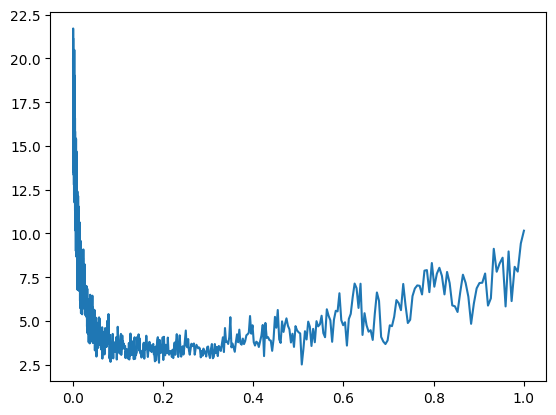

In [133]:
plot.plot(lri, lossi);

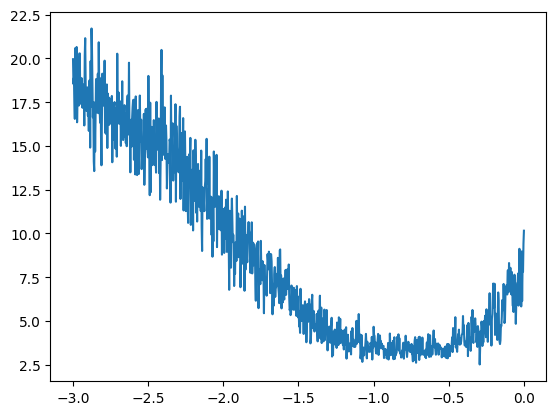

In [134]:
plot.plot(lrei, lossi);

We can observe from the graph that the loss starts decrease as the learning rate slowly increases first but after around 0.2 the loss starts to become unstable. A good learing rate exponent is somewhere around -1.0 i.e. `lr=0.1`.

So now that we have confidence that 0.1 is a good learning rate we train our model for more iterations using that learning rate.

In [126]:
params = init_params()
params = train(10_000, params, X, 32, 0.1, False)
loss = get_loss(params, X)
print(f'Overall Loss: {loss}')

3481
Overall Loss: 2.5127880573272705


### Learning Rate Decay

As we keep training with the same learning rate our loss decreases to a local minimum, it plateaus, so we reduce the learning rate to improve the training.

In [127]:
params = init_params()
params = train(10_000, params, X, 32, 0.1, False)
loss = get_loss(params, X)
print(f'Overall Loss: {loss}')

# training again with same params but lower lr
params = train(10_000, params, X, 32, 0.01, False)
loss = get_loss(params, X)
print(f'Overall Loss: {loss}')

3481
Overall Loss: 2.4706618785858154
Overall Loss: 2.39115834236145


## Creating Training, Validation And Test Splits

In [12]:
def build_dataset(words):
    block_size = 3 
    X, Y = [], []

    for w in words:
        context = [0] * block_size 
        for ch in w + '.':
            ix = chtoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 


    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    
    return X, Y

In [13]:
random.shuffle(words)

In [14]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [138]:
n1, n2

(25626, 28829)

In [15]:
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182637, 3]) torch.Size([182637])
torch.Size([22778, 3]) torch.Size([22778])
torch.Size([22731, 3]) torch.Size([22731])


## Training Using New Splits

Updating our `train` function to use `Ytr` to calculate loss because we'll always train on `Xtr`

In [30]:
def train(n_iters, params, Xtr, batch_size, lr, print_loss=True):
    C = params[0]
    W1 = params[1]
    B1 = params[2]
    W2 = params[3]
    B2 = params[4]
    
    for _ in range(n_iters):
        # create batches
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        emb = C[Xtr[ix]]

        # forward pass
        h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Ytr[ix])

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()
        
        #update
        for p in params:
            p.data += -lr * p.grad

        if print_loss:
            print(loss.item()) # batch-wise loss

    return params

In [31]:
params = init_params()
params = train(10_000, params, Xtr, 32, 0.1, False)

3481


In [32]:
def get_loss(params, split='train'):
    if split == 'val':
        X = Xval
        Y = Yval
    elif split == 'test':
        X = Xtest
        Y = Ytest  
    else:
        X = Xtr
        Y = Ytr    

    C = params[0]
    W1 = params[1]
    B1 = params[2]
    W2 = params[3]
    B2 = params[4]
    
    emb = C[X] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y)
    
    return loss.item()

In [33]:
# overall loss on training set
print(get_loss(params))

2.4607298374176025


In [34]:
# overall loss on validation set
print(get_loss(params, 'val'))

2.465745687484741


In [35]:
print(get_loss(params, 'test'))

2.4647867679595947


Right now the training and validation loss are almost equal. That's how we know we're not overfitting.

## Using A Larger Hidden Layer

Our model is not powerful enough to just memorise the data because our training and validation losses are almost equal so we're not overfitting, we're underfitting. That means that our network is very small and we can expect to make performance improvements by scaling up the size of the model.

### Increasing The Number Of Neurons In The Hidden Layer

In [36]:
def init_params(n_embed, block_size, vocab_size, n_hidden):
    C = torch.randn((27, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden))
    B1 = torch.randn(n_hidden)
    W2 = torch.randn((n_hidden, vocab_size))
    B2 = torch.randn(vocab_size)
    
    params = [C, W1, B1, W2, B2]

    print(sum(p.nelement() for p in params))

    for p in params:
        p.requires_grad = True

    return params    

In [37]:
params = init_params(2, 3, 27, 300)

10281


Our parameters have increased from 3481 to 10281

In [38]:
lr = 0.1
lossi = []
stepi = []

In [39]:
def train(n_iters, params, Xtr, batch_size, lr, n_embed, block_size, print_loss=True):
    C = params[0]
    W1 = params[1]
    B1 = params[2]
    W2 = params[3]
    B2 = params[4]
    
    lossi = []
    stepi = []  

    for i in range(n_iters):
        # create batches
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        emb = C[Xtr[ix]]

        # forward pass
        h = torch.tanh(emb.view(-1, n_embed*block_size) @ W1 + B1)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Ytr[ix])

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()
        
        #update
        for p in params:
            p.data += -lr * p.grad

        if print_loss:
            print(loss.item()) # batch-wise loss

        stepi.append(i)
        lossi.append(loss.item())       

    return params, stepi, lossi

In [40]:
params, stepi, lossi = train(30_000, params, Xtr, 32, 0.1, 2, 3, False)

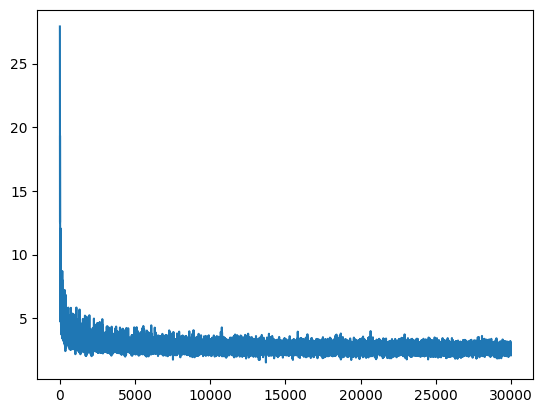

In [41]:
plot.plot(stepi, lossi)

The lines have a bit of a height to them after optimizing. That's because we're using mini batches which add a little bit of noise.

In [42]:
#losses
print(get_loss(params))
print(get_loss(params, 'val'))

2.7160401344299316
2.7215185165405273


In [43]:
# performing more iterarations until our loss plateaus
params, stepi, lossi = train(30_000, params, Xtr, 32, 0.1, 2, 3, False)
print(get_loss(params))
print(get_loss(params, 'val'))

2.5742297172546387
2.6006832122802734


In [44]:
# training further with a reduced lr
params, stepi, lossi = train(60_000, params, Xtr, 32, 0.01, 2, 3, False)
print(get_loss(params))
print(get_loss(params, 'val'))

2.26013445854187
2.2828927040100098


After training we have improved the loss but not by much because our larger network requires more training to converge to a lower loss.

We can continue training it more and check if the loss improves. Another reason can be that our batch size is very low that we have too much noise in the training data and we might want to increase it to have a better gradient.

Another reason can be that the bottleneck of the network right now could be our 2D embeddings. We might be scramming way too many characters into just a 2D vector and the network isn't really able to use that vector space effectively.

### Visualizing The 2D Character Embeddings Trained By The Network

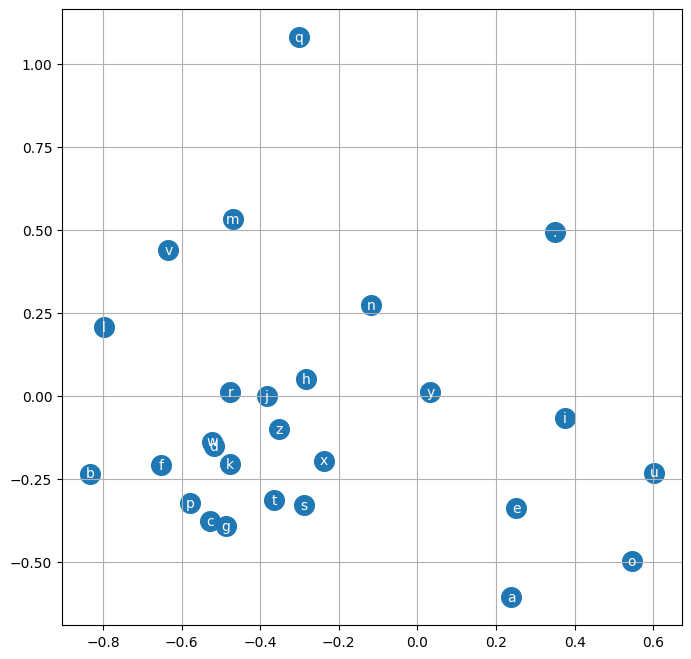

In [48]:
C = params[0]
plot.figure(figsize=(8, 8))
plot.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plot.text(C[i, 0].item(), C[i, 1].item(), itoch[i], ha="center", va="center", color="white")
plot.grid("minor")    

## Using Larger Embedding Vectors

Instead of 2D embeddings let's try embeddings of 10 dimensions and have 200 neurons in the hidden layer.

In [49]:
params = init_params(10, 3, 27, 200)

11897


We'll also modify the training function to keep track of log losses instead of losses.

In [50]:
def train(n_iters, params, Xtr, batch_size, lr, n_embed, block_size, print_loss=True):
    C = params[0]
    W1 = params[1]
    B1 = params[2]
    W2 = params[3]
    B2 = params[4]
    
    lossi = []
    stepi = []  

    for i in range(n_iters):
        # create batches
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        emb = C[Xtr[ix]]

        # forward pass
        h = torch.tanh(emb.view(-1, n_embed*block_size) @ W1 + B1)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Ytr[ix])

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()
        
        #update
        for p in params:
            p.data += -lr * p.grad

        if print_loss:
            print(loss.item()) # batch-wise loss

        stepi.append(i)
        lossi.append(loss.log10().item())       

    return params, stepi, lossi

We'll also have to modify our `get_loss` function to handle variable number of `n_embd` and `block_size`.

In [51]:
def get_loss(params,  n_embd, block_size, split='train',):
    if split == 'val':
        X = Xval
        Y = Yval
    elif split == 'test':
        X = Xtest
        Y = Ytest  
    else:
        X = Xtr
        Y = Ytr    

    C = params[0]
    W1 = params[1]
    B1 = params[2]
    W2 = params[3]
    B2 = params[4]
    
    emb = C[X] 
    h = torch.tanh(emb.view(-1, n_embd*block_size) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y)
    
    return loss.item()

In [52]:
params, stepi, lossi = train(100_000, params, Xtr, 32, 0.1, 10, 3, False)
print(get_loss(params, 10, 3))
print(get_loss(params, 10, 3, 'val'))

2.3660852909088135
2.42726731300354


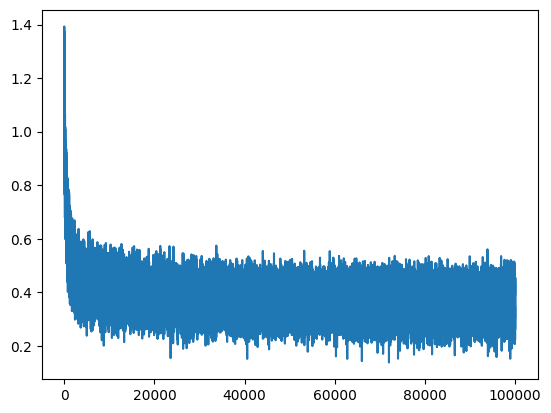

In [53]:
# plotting the log loss
plot.plot(stepi, lossi);

In [54]:
# more iterations
params, stepi, lossi = train(100_000, params, Xtr, 32, 0.1, 10, 3, False)
print(get_loss(params, 10, 3))
print(get_loss(params, 10, 3, 'val'))

2.2269513607025146
2.304068088531494


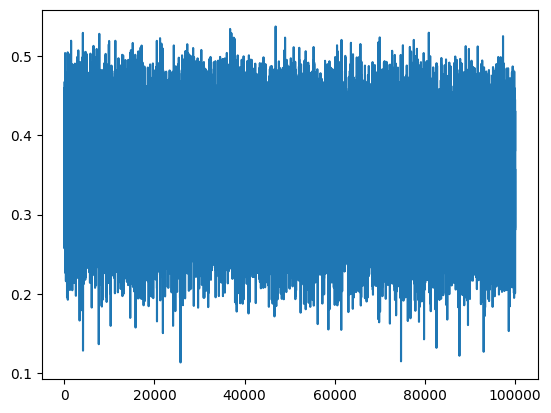

In [55]:
plot.plot(stepi, lossi);

In [56]:
# training on reduced lr 
params, stepi, lossi = train(100_000, params, Xtr, 32, 0.01, 10, 3, False)
print(get_loss(params, 10, 3))
print(get_loss(params, 10, 3, 'val'))

2.0929949283599854
2.170815944671631


Notice how the training and the validation losses have started to diverge now so maybe the network is getting good enough now that we are slowly starting to overfit.

We can try out many combinations of hyperparams to further improve the network

- Modify the size of the network
- Size of the embeddings
- Modify the batch size
- Increase the number of characters in a single series
- How many iterations to run
- How the learining rate decays

### Task

At the end of the lecture the loss after training for 200,000 iter at learning rate of 0.1 for first 100k and then 0.01 was 2.12 and 2.17 on training and validation sets resp. The goal is to try to get a better loss by modifying the params.

## Sampling From The Model

In [58]:
C = params[0]
W1 = params[1]
B1 = params[2]
W2 = params[3]
B2 = params[4]

for _ in range(20):
    out = []
    context = [0] * block_size # init context with all dots ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + B1)
        logits = h @ W2 + B2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itoch[i] for i in out))    

karou.
winko.
davia.
jackin.
reene.
arry.
evedy.
maual.
dyla.
mae.
frong.
juna.
rosa.
aasi.
deion.
juvian.
jhitel.
kata.
rihet.
tylvin.


Our words now look a bit more namelike but we can improve further.

## Summary Notes

![Multi Layer Perceptron Network Diagram](diagrams/multi_layer_perceptron.png)

- We are training a multilayered perceptron which has one hidden layer and one output layer.
- Our input dataset consists all the names broken into sequences of three characters each. Each name begins with `...` and ends with `.`. Sequence is of three characters because the `block_size` is set to three. These make up the input sequences. Each input sequence has a corresponding target character which is the character that comes next after the sequence. So our dataset is comprised of tokenezied inputs `X(228146, 3)` and targets `Y(228146)`
- To pass our inputs to the network we have to convert them to vector embeddings. We have chosen to encode each of our 27 tokens to have a 2 dimensional vector embedding i.e. `n_embd=2`. So by embedding our inputs `X(228146, 3)` we get our input embeddings `emb(228146, 3, 2)` as each token has its 2d embedding.
- This step can also be seen a the first layer of our network if we take `one_hot(27, 27)` encoding of our inputs and perform matmul on `weights(27, 2)` the output will be exactly the same as what we have in 2D vector embeddings.
- Our single input sequence of 3 tokens `(1, 3)` has now become embeddings of `dim(3, 2)` so we concatenate these three rows to make our single input embeddings of `dim(1, 6)` for a series of 3 tokens. This becomes the input to our network for a corresponding series of three tokens. So our `emb` vector has `dim(228146, 6)` which becomes the input for our hidden layer.
- The hidden layer has `n_hidden=100` neurons in it. It's `weight` matrix has `dim(6, 100)` and `bias` has `dim(100)`. The output after performing the matrix multiplication is passed to the `tanh` non-linearity function to get the activations after the first layer of `dim(228146, 100)` which becomes the input for our output layer.
- The output layer has `weight` matrix of `dim(100, 27)` and `bias` of `dim(27)` to give us the activations for each of our 27 tokens in our vocab for a given input to the network. These are the `logits` from the network.
- Finally we perform a `softmax` over the logits to get the probability distribution generated by the network for the given input.
- The loss functions is the `cross_entropy` loss function of `logits` and the target tokens `Y` and is calculated in the same manner we calculated `NLL` for the Bigram Network.
- We optimize the weights of the network against this loss function using gradient descent to train our network.